In [138]:
import pandas as pd
import numpy  as np
import matplotlib.pyplot as plt
import pickle

from datetime import datetime

## Preprocessing and filtering

In [139]:
fx_eu_per_usd = pd.read_csv('data_christina/fx_usd_eur.csv')
fx_eu_per_usd = fx_eu_per_usd[['Date', 'Close']].iloc[1:,:] ## Dropping first row to match time series with utilities
fx_eu_per_usd = fx_eu_per_usd.rename(columns = {'Close': 'fx'})
fx_eu_per_usd['Date'] = fx_eu_per_usd.Date.apply(lambda date: datetime.strptime(date, f'%Y-%m-%d'))
fx_eu_per_usd = fx_eu_per_usd.set_index('Date')

fx_eu_per_usd_yearly = fx_eu_per_usd.groupby(fx_eu_per_usd.index.year).mean()

In [140]:
data_acc_eu = pd.read_csv('data_christina/eu_acc.csv')
data_acc_eu = data_acc_eu[data_acc_eu['fyear'] > 2010]
data_acc_eu = data_acc_eu.drop(columns=['sedol'])

data_acc_us = pd.read_csv('data_christina/us_acc.csv')
data_acc_us = data_acc_us[data_acc_us['fyear'] > 2010]
data_acc_us['loc'] = 'USA'


In [141]:
## Convert everything to dollars.

variables = ['lt', 'at', 'sich', 'che', 'ebitda', 'ppent', 'dltt', 'dlc', 'capx', 'dvt'] ##  numerical variables in data_acc_eu
data_acc_eu = pd.merge(data_acc_eu, fx_eu_per_usd_yearly, right_index=True, left_on='fyear').sort_index() ## adding fx yearly

data_acc_eu[variables] = data_acc_eu[variables].div(data_acc_eu.fx, axis=0)

data_acc = pd.concat([data_acc_eu, data_acc_us])

In [142]:
data = pd.read_csv('data_christina/zo18ojgbh8zepkwc.csv', delimiter=',')

/home/ignacio/miniconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3441: DtypeWarning: Columns (1,4,13,16,21) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [143]:
## The idea is to create a dictionary with 2 entries. US or EU. In each category we have a dictionary pero country in that category.
## Each of those dictionaries contains 1 key per company. Behind each key is stored a pandas datafram with the company neccesary info.

time_series = {}

european_countries = np.array(['ESP', 'PRT', 'DEU', 'AUT', 'ITA', 'CZE', 'FRA', 'FIN', 'GRC', 'SWE'])

na_countries = np.array(['USA'])


## European companies

time_series_eu = {}

for country in european_countries:
    companies = data[data['loc'] == country]['conm'].unique() ## Gets the names of the companies in a given country
    
    time_series_country = {}
    
    for company in companies:
        data_company = data[data['conm'] == company].copy()
        
        tic = data_company.tic.unique()[0] ## Get the first tic of the company
    
        data_company = data_company[data_company['tic'] == tic]
        
        data_company['datadate'] = data_company.datadate.apply(lambda date: datetime.strptime(date, f'%Y-%m-%d'))
        data_company = data_company.set_index('datadate')
        
        time_series_country[company] = data_company
        
    time_series_eu[country] = time_series_country
    
time_series['EU'] = time_series_eu

## NA companies

time_series_na = {}

for country in na_countries:
    companies = data[data['loc'] == country]['conm'].unique() ## Gets the names of the companies in a given country
    
    time_series_country = {}
    
    for company in companies:
        data_company = data[data['conm'] == company].copy()
        
        tic = data_company.tic.unique()[0] ## Get the first tic of the company
    
        data_company = data_company[data_company['tic'] == tic]
        
        data_company['datadate'] = data_company.datadate.apply(lambda date: datetime.strptime(date, f'%Y-%m-%d'))
        data_company = data_company.set_index('datadate')
        
        time_series_country[company] = data_company        
        
    time_series_na[country] = time_series_country
    
time_series['NA'] = time_series_na

In [144]:
def drop_series_from_conm_list(series, drop_companies):
    
    for continent in ['EU', 'NA']:
        countries = time_series[continent].keys()

        for country in countries:
            companies = list(time_series[continent][country].keys())
            
            for company in companies:
                if company in drop_companies:
                    del series[continent][country][company]
    
    return series

In [145]:
## Adding the fx to each serie, converting prices to USD and calculating cumulative returns in USD.

for continent in ['EU', 'NA']:
    countries = time_series[continent].keys()
    
    for country in countries:
        companies = time_series[continent][country].keys()
        
        for company in companies:
            time_series[continent][country][company] = pd.merge(time_series[continent][country][company], fx_eu_per_usd, left_index=True,right_index=True)
            
            ## Changing rates to USD
            
            if continent == 'EU':
                time_series[continent][country][company]['prccd'] = time_series[continent][country][company]['prccd'] / time_series[continent][country][company]['fx']
            
            ## Calculating log returns and cumulative returns
            
            time_series[continent][country][company]['log_returns'] = time_series[continent][country][company]['prccd'].apply(lambda x: np.log(x)).diff()
            time_series[continent][country][company]['log_returns'].iloc[0] = 0
            
            time_series[continent][country][company]['cum_returns'] = time_series[continent][country][company]['log_returns'].cumsum()



/home/ignacio/miniconda3/lib/python3.9/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [146]:
################################################# Filters in the company general data #################################################

## Filter companies whose lt (total liabilities) is larger than their at

eu_comps_bad = []

for company in data_acc_eu.conm.unique():
    df = data_acc_eu[data_acc_eu['conm'] == company]
    
    condition = (df['lt'] > df['at']).max() ## if at some point lt > at then True
    
    if condition:
        eu_comps_bad.append(company)

print('In Europe')        
print(f'num tot companies:  {len(data_acc_eu.conm.unique())}')
print(f'num bad companies:  {len(eu_comps_bad)}')
print(f'num good companies: {len(data_acc_eu.conm.unique()) - len(eu_comps_bad)}')


us_comps_bad = []

for company in data_acc_us.conm.unique():
    df = data_acc_us[data_acc_us['conm'] == company]
    
    condition = (df['lt'] > df['at']).max() ## if at some point lt > at then True
    
    if condition:
        us_comps_bad.append(company)

        
print('In US')
print(f'num tot companies:  {len(data_acc_us.conm.unique())}')
print(f'num bad companies:  {len(us_comps_bad)}')
print(f'num good companies: {len(data_acc_us.conm.unique()) - len(us_comps_bad)}')

bad_comps = eu_comps_bad + us_comps_bad

################################################# Filters on the time series #################################################

## Deleting penny companies

penny_companies = []

for continent in ['EU', 'NA']:
    countries = time_series[continent].keys()
    
    for country in countries:
        companies = time_series[continent][country].keys()
        
        for company in companies:

            ## Saving penny stocks
            
            penny_stock = False
            if continent == 'NA':
                threshold   = time_series[continent][country][company].prccd.quantile(0.05)
                penny_stock = threshold < 5 
            
            if penny_stock:
                penny_companies.append(company)
                continue


################################################# Dropping the companies by General filter #################################################

## In general data
for company in bad_comps:
    data_acc = data_acc[data_acc['conm'] != company]

## in time series data
time_series = drop_series_from_conm_list(time_series, bad_comps)
    
################################################# Imposing general filter in time-series #################################################

time_series = drop_series_from_conm_list(time_series, penny_companies)

time_series_conms = []

for continent in ['EU', 'NA']:
    countries = time_series[continent].keys()
    
    for country in countries:
        companies = time_series[continent][country].keys()
        
        for company in companies:
            time_series_conms.append(company)

data_acc = data_acc[data_acc['conm'].isin(time_series_conms)]
            
for company in penny_companies:
    data_acc = data_acc[data_acc['conm'] != company]

    
    
################################################# Saving the clean data #################################################

data_acc.to_csv('data_christina/data_acc_clean.csv', index = False)

with open('data_christina/time_series.pickle', 'wb') as handle:
    pickle.dump(time_series, handle, protocol=pickle.HIGHEST_PROTOCOL)

In Europe
num tot companies:  165
num bad companies:  17
num good companies: 148
In US
num tot companies:  385
num bad companies:  40
num good companies: 345


## new section

In [148]:
################################################# Load clean data #################################################

data_acc = pd.read_csv('data_christina/data_acc_clean.csv')

with open('data_christina/time_series.pickle', 'rb') as handle:
    time_series = pickle.load(handle)

In [149]:
data[data['conm'] == 'CORNING NATURAL GAS HLDG CP']['exchg'].unique()

array([19])

In [20]:
fx_eu_per_usd['Date']

1       2010-01-04
2       2010-01-05
3       2010-01-06
4       2010-01-07
5       2010-01-08
           ...    
3490    2023-05-19
3491    2023-05-22
3492    2023-05-23
3493    2023-05-24
3494    2023-05-25
Name: Date, Length: 3494, dtype: object

In [32]:
time_series['EU']['DEU']['RWE AG'] == fx_eu_per_usd['Date']

KeyError: 'datadate'

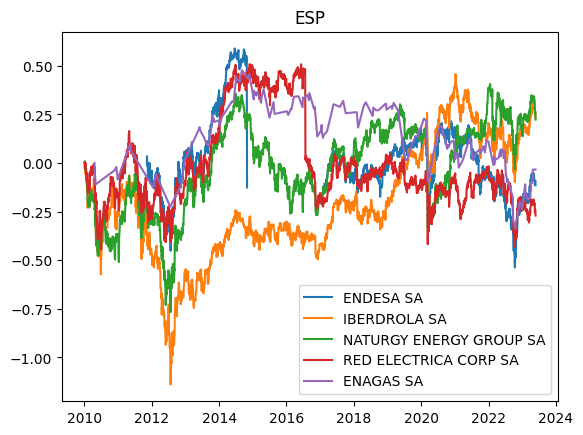

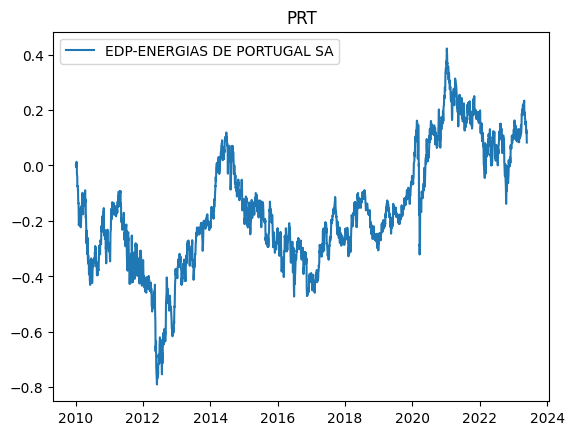

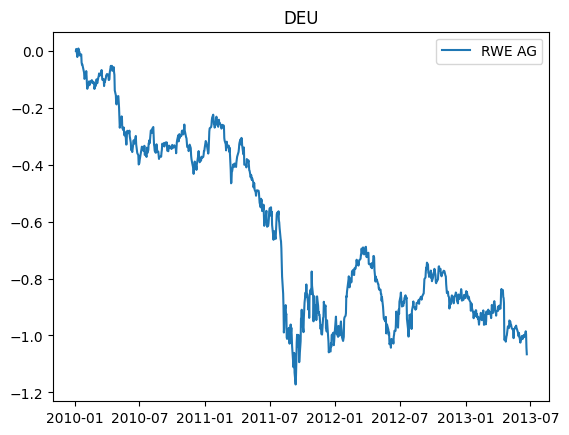

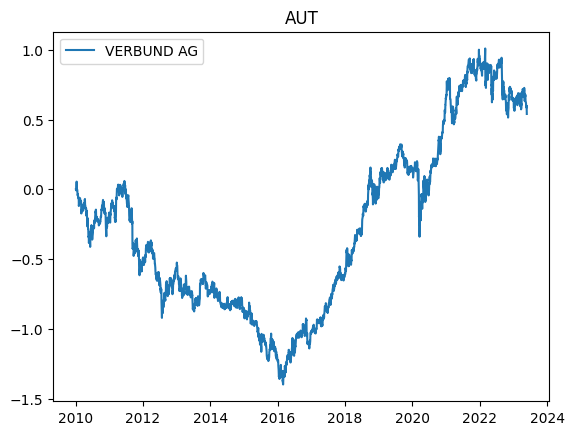

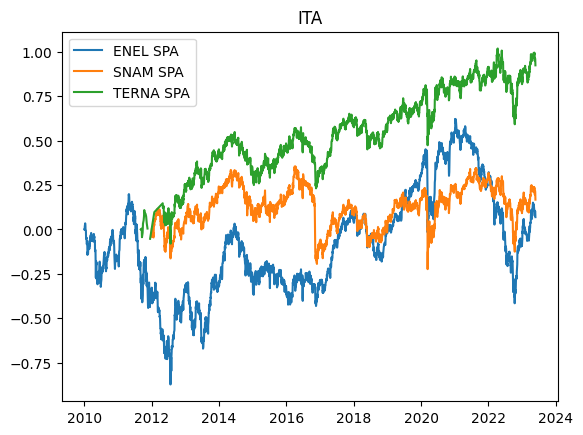

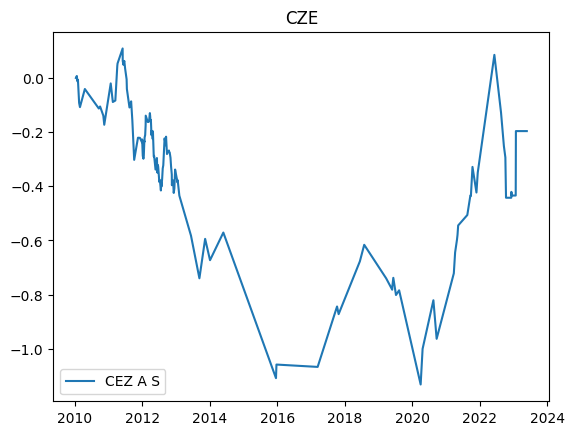

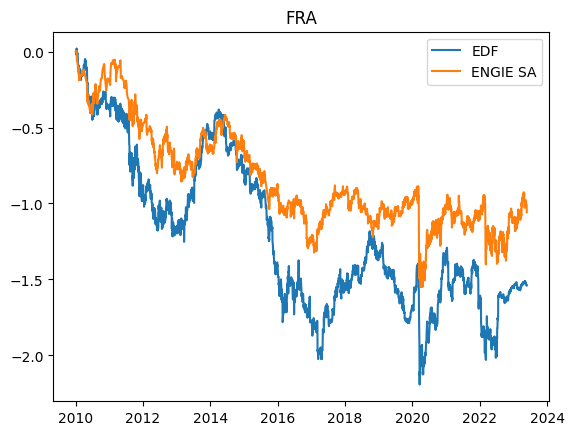

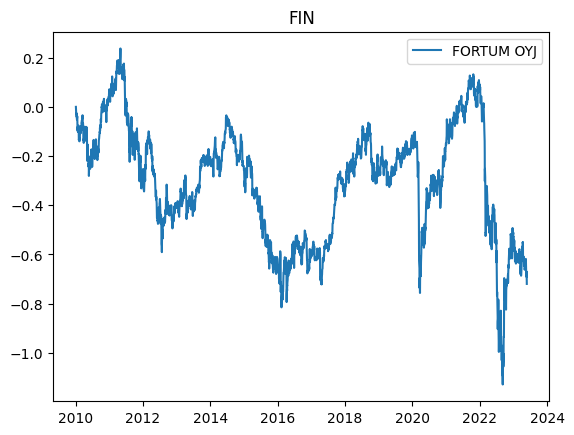

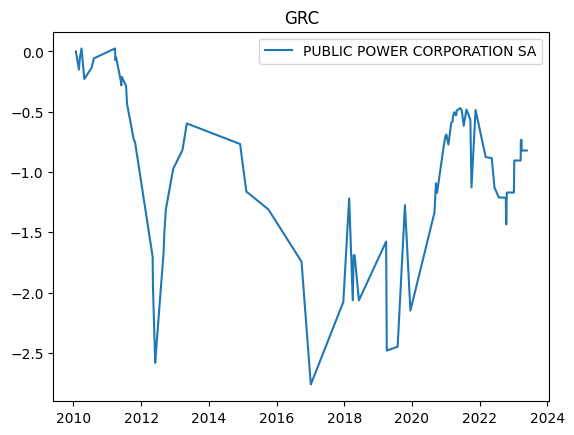

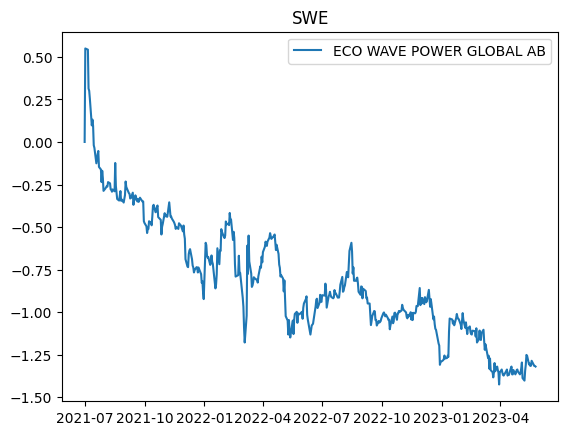

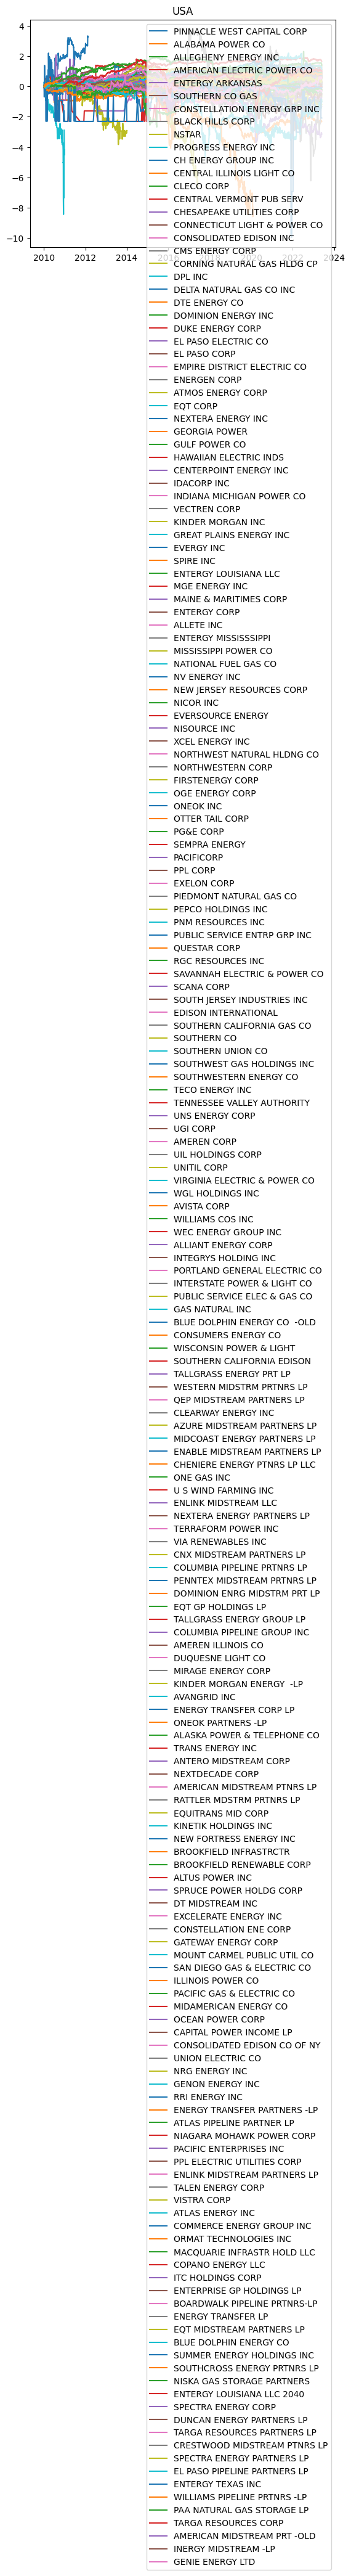

In [6]:
for continent in ['EU', 'NA']:
    countries = time_series[continent].keys()
    
    for country in countries:
        companies = time_series[continent][country].keys()
        
        for company in companies:
            plt.plot(time_series[continent][country][company]['datadate'], time_series[continent][country][company]['cum_returns'], label = company)
            
        plt.legend()
        plt.title(f'{country}')
        plt.show()

In [8]:
portfolios = {}

for continent in ['EU', 'NA']:
    countries = time_series[continent].keys()
    
    first_comp = True
    
    for country in countries:
        companies = time_series[continent][country].keys()
        
        for company in companies:
            
            data = time_series[continent][country][company].rename(columns={'cum_returns': f'cum_returns_{company}'})
            
            if first_comp:
                portfolio = data[['datadate', f'cum_returns_{company}']]
                first_comp = False
            else:
                portfolio = pd.merge(portfolio, data[['datadate',f'cum_returns_{company}']],
                            how = 'outer', left_on= 'datadate', right_on = 'datadate' )
                
    portfolio = portfolio.sort_values(by = ['datadate']).set_index('datadate')
    portfolio['avg_cum_returns'] = np.nanmean(portfolio,axis=1)
    portfolios[continent] = portfolio

In [9]:
def generate_summ_stats_continet():

#   fist_jan     = portfolio.index.values[2524]
    fist_jan     = portfolio.index.values[2587]
    gas_crisis   = portfolio.index.values[2945]

    serie1 = portfolios['EU'][fist_jan:gas_crisis]['avg_cum_returns'].agg([ "mean","std", "median"])
    serie2 = portfolios['NA'][fist_jan:gas_crisis]['avg_cum_returns'].agg([ "mean","std", "median"])

    df_prior = pd.concat({'EU': serie1, 'US':serie2}, axis = 1)
    print(df_prior.transpose().to_latex())
    
    serie1 = portfolios['EU'][gas_crisis:]['avg_cum_returns'].agg([ "mean","std", "median"])
    serie2 = portfolios['NA'][gas_crisis:]['avg_cum_returns'].agg([ "mean","std", "median"])
    df_post = pd.concat({'EU': serie1, 'US':serie2}, axis = 1)
    print(df_post.transpose().to_latex())
    return df_prior.transpose(), df_post.transpose()

In [58]:
for data in df:
    data['ra_returns'] = data['mean'].values/data['std'].values
    data.drop(['mean','std'],axis = 1,inplace=True)
    
    print(data.to_latex())

\begin{tabular}{lrr}
\toprule
{} &    median &  ra\_returns \\
\midrule
EU & -0.024857 &   -0.594852 \\
US &  0.216011 &    2.265328 \\
\bottomrule
\end{tabular}

\begin{tabular}{lrr}
\toprule
{} &    median &  ra\_returns \\
\midrule
EU & -0.197276 &   -1.636168 \\
US &  0.277873 &    5.480243 \\
\bottomrule
\end{tabular}



In [54]:
df

(      median  ra_returns
 EU -0.024857   -0.594852
 US  0.216011    2.265328,
       median  ra_returns
 EU -0.197276   -1.636168
 US  0.277873    5.480243)

In [57]:
df = generate_summ_stats_continet()

\begin{tabular}{lrrr}
\toprule
{} &      mean &       std &    median \\
\midrule
EU & -0.071760 &  0.120636 & -0.024857 \\
US &  0.192765 &  0.085094 &  0.216011 \\
\bottomrule
\end{tabular}

\begin{tabular}{lrrr}
\toprule
{} &      mean &       std &    median \\
\midrule
EU & -0.182133 &  0.111317 & -0.197276 \\
US &  0.280571 &  0.051197 &  0.277873 \\
\bottomrule
\end{tabular}



In [33]:
portfolio.index.values[2565]

numpy.datetime64('2020-03-02T00:00:00.000000000')

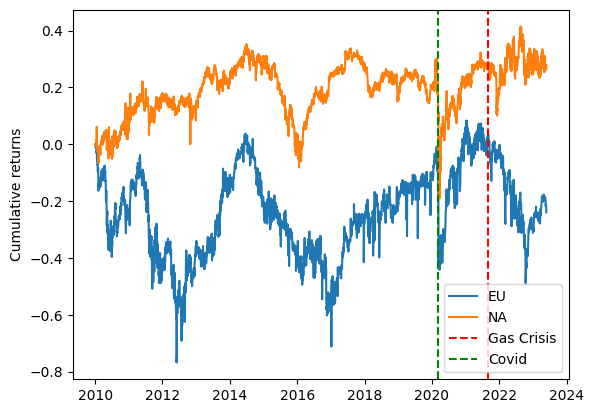

In [10]:
gas_crisis   = portfolio.index.values[2945]
covid_crisis = portfolio.index.values[2565]

for continent in ['EU', 'NA']:
    portfolio = portfolios[continent]
    plt.plot(portfolio.index.values, portfolio['avg_cum_returns'], label = continent)
    
plt.axvline(x = gas_crisis, color = 'red', linestyle="--", label = 'Gas Crisis')
plt.axvline(x = covid_crisis, color = 'green', linestyle="--", label = 'Covid')
plt.legend()
plt.ylabel('Cumulative returns')
plt.savefig('Figures/eu_vs_na.pdf')
plt.show()

0.7221409736602291

In [35]:
gas_crisis

numpy.datetime64('2021-09-01T00:00:00.000000000')

In [40]:
spread[gas_crisis:].argmax()

280

0.2663084570952536
0.4627040972457777
0.7374742893736832
0.7221409736602291
280 2022-10-25T00:00:00.000000000


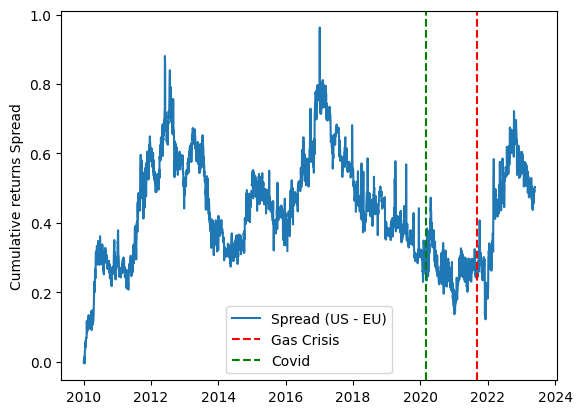

In [44]:
gas_crisis   = portfolio.index.values[2945]
covid_crisis = portfolio.index.values[2565]


spread = pd.merge(portfolios['EU']['avg_cum_returns'], portfolios['NA']['avg_cum_returns'], left_index=True, right_index=True )
spread = spread['avg_cum_returns_y'] - spread['avg_cum_returns_x']
plt.plot(spread.index.values, spread , label = 'Spread (US - EU)')

avg_1 = np.mean(spread[covid_crisis:gas_crisis])
avg_2 = np.mean(spread[gas_crisis:])

print(avg_1)
print(avg_2)
print((avg_2 - avg_1) / avg_1)
print(spread[gas_crisis:].max())
print(spread[gas_crisis:].argmax(), spread.index.values[2945 + spread[gas_crisis:].argmax()] )

plt.axvline(x = gas_crisis, color = 'red', linestyle="--", label = 'Gas Crisis')
plt.axvline(x = covid_crisis, color = 'green', linestyle="--", label = 'Covid')
plt.legend()
plt.ylabel('Cumulative returns Spread')
plt.savefig('Figures/spread_eu_vs_na.pdf')
plt.show()

print()

In [31]:
spread.values[gas_crisis:]

TypeError: slice indices must be integers or None or have an __index__ method

In [27]:
np.argmax(np.max(spread.values[gas_crisis:]))

TypeError: slice indices must be integers or None or have an __index__ method

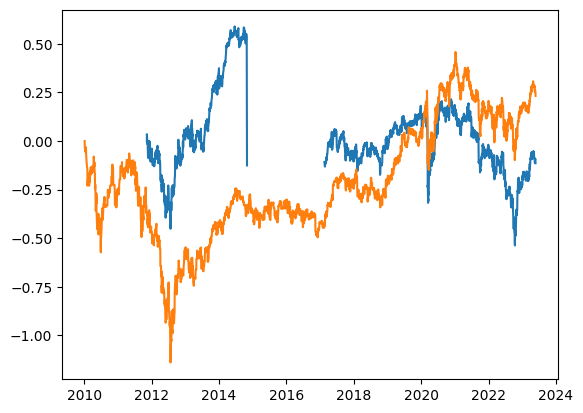

In [24]:
plt.plot(time_series['EU']['ESP']['ENDESA SA']['datadate'], time_series['EU']['ESP']['ENDESA SA']['cum_returns'])
plt.plot(time_series['EU']['ESP']['IBERDROLA SA']['datadate'], time_series['EU']['ESP']['IBERDROLA SA']['cum_returns'])
plt.show()

In [29]:
data[data['loc'] == 'FRA']['conm'].unique()

,gvkey,iid,datadate,tic,cusip,conm,ajexdi,cshoc,cshtrd,prccd,...,secstat,tpci,cik,fic,ein,loc,naics,priusa,sic,ipodate
511293,15321,91,2011-11-10,ELEZY,29258N206,ENDESA SA,1.0,1.058752e+09,0.0,11.033,...,A,F,1046649.0,ESP,NaN,ESP,22111,91.0,4911,NaN
511294,15321,91,2011-11-11,ELEZY,29258N206,ENDESA SA,1.0,1.058752e+09,0.0,11.431,...,A,F,1046649.0,ESP,NaN,ESP,22111,91.0,4911,NaN
511295,15321,91,2011-11-14,ELEZY,29258N206,ENDESA SA,1.0,1.058752e+09,0.0,11.108,...,A,F,1046649.0,ESP,NaN,ESP,22111,91.0,4911,NaN
511296,15321,91,2011-11-15,ELEZY,29258N206,ENDESA SA,1.0,1.058752e+09,0.0,10.913,...,A,F,1046649.0,ESP,NaN,ESP,22111,91.0,4911,NaN
511297,15321,91,2011-11-16,ELEZY,29258N206,ENDESA SA,1.0,1.058752e+09,0.0,10.990,...,A,F,1046649.0,ESP,NaN,ESP,22111,91.0,4911,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
513619,15321,91,2023-05-19,ELEZY,29258N206,ENDESA SA,1.0,1.058752e+09,0.0,10.757,...,A,F,1046649.0,ESP,NaN,ESP,22111,91.0,4911,NaN
513620,15321,91,2023-05-22,ELEZY,29258N206,ENDESA SA,1.0,1.058752e+09,0.0,10.821,...,A,F,1046649.0,ESP,NaN,ESP,22111,91.0,4911,NaN
513621,15321,91,2023-05-23,ELEZY,29258N206,ENDESA SA,1.0,1.058752e+09,0.0,10.827,...,A,F,1046649.0,ESP,NaN,ESP,22111,91.0,4911,NaN
513622,15321,91,2023-05-24,ELEZY,29258N206,ENDESA SA,1.0,1.058752e+09,0.0,10.668,...,A,F,1046649.0,ESP,NaN,ESP,22111,91.0,4911,NaN


In [13]:
np.array(data.keys())

array(['gvkey', 'iid', 'datadate', 'tic', 'cusip', 'conm', 'ajexdi',
       'cshoc', 'cshtrd', 'prccd', 'trfd', 'exchg', 'secstat', 'tpci',
       'cik', 'fic', 'ein', 'loc', 'naics', 'priusa', 'sic', 'ipodate'],
      dtype=object)

In [14]:
print(data.head())

   gvkey iid    datadate  tic      cusip                        conm  ajexdi  \
0   1075  01  2010-01-04  PNW  723484101  PINNACLE WEST CAPITAL CORP     1.0   
1   1075  01  2010-01-05  PNW  723484101  PINNACLE WEST CAPITAL CORP     1.0   
2   1075  01  2010-01-06  PNW  723484101  PINNACLE WEST CAPITAL CORP     1.0   
3   1075  01  2010-01-07  PNW  723484101  PINNACLE WEST CAPITAL CORP     1.0   
4   1075  01  2010-01-08  PNW  723484101  PINNACLE WEST CAPITAL CORP     1.0   

         cshoc     cshtrd  prccd  ...  secstat  tpci       cik  fic  \
0  101281000.0   873483.0  36.88  ...        A     0  764622.0  USA   
1  101281000.0  1432202.0  36.38  ...        A     0  764622.0  USA   
2  101281000.0   961085.0  36.76  ...        A     0  764622.0  USA   
3  101281000.0   685959.0  36.69  ...        A     0  764622.0  USA   
4  101281000.0   613973.0  36.92  ...        A     0  764622.0  USA   

          ein  loc naics priusa   sic  ipodate  
0  86-0512431  USA  2211    1.0  4911      